In [28]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from pathlib import Path
import json

from sklearn.base import clone
from sklearn.model_selection import cross_validate, StratifiedKFold, StratifiedGroupKFold, GroupKFold

from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import  make_scorer
from sklearn.metrics import RocCurveDisplay
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.model_selection import train_test_split

# import altair as alt
import mlflow
from mlflow.models import infer_signature


from lightgbm import LGBMRanker, LGBMClassifier, plot_importance


from sklearn.metrics import make_scorer, roc_auc_score, precision_score, recall_score
average_precision_scorer = make_scorer(average_precision_score, average='macro')  #, average = 'weighted')
roc_auc_scorer = make_scorer(roc_auc_score, average='macro') #average = 'weighted')


from hyperopt import fmin, hp, tpe, STATUS_OK, Trials, space_eval
import seaborn as sns
# from mlflow_utils import train_log_model

idx = pd.IndexSlice
import pylab as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from model import get_model
from metrics import (
    precision_at_f, precision_at_85,
    recall_at_85, recall_at_f
)

In [3]:
from mlflow_utils import mlflow_log_model

In [4]:
import boto3

boto3.session.Session().available_profiles

['se-stage',
 'se-prod',
 'zgdatalake',
 'zgdatalake-staging',
 'sedatalakeprodreadonly',
 'sedatalakeprodreadwrite',
 'sedatalakeadmin',
 'sedatalakestagingreadonly',
 'sedatalakestagingreadwrite',
 'sedatalakeadmin-stage',
 'default']

In [5]:
# boto3.setup_default_session(profile_name='sedatalakestagingreadwrite')
boto3.setup_default_session(profile_name='sedatalakeprodreadwrite')

In [6]:
METRICS = [
    make_scorer(average_precision_score, average='macro'),  #, average = 'weighted')
    make_scorer(roc_auc_score, average='macro'),
    make_scorer(precision_at_f, needs_proba=True, greater_is_better=True),
    make_scorer(recall_at_f, needs_proba=True, greater_is_better=True)
]


/Users/philippk/Library/Caches/pypoetry/virtualenvs/transaction-matching-i9O2AM3V-py3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


## Load Data

In [37]:
trxn_ids_train = pd.read_parquet('./data/train/trxn_id_train.parquet')

In [36]:
# data

In [7]:
X_train = pd.read_parquet('./data/train/X_query_train.parquet')
y_train = pd.read_parquet('./data/train/y_query_train.parquet').iloc[:, 0]

In [8]:
X_val = pd.read_parquet('./data/train/X_query_val.parquet')
y_val = pd.read_parquet('./data/train/y_query_val.parquet').iloc[:, 0]

In [9]:
X_old_val = pd.read_parquet('./data/train/Xval.parquet')
y_old_val = pd.read_parquet('./data/train/yval.parquet').iloc[:, 0]

In [87]:
w_train = np.where(y_train, 50, 1)

In [10]:
# with open('./data/train/groups.json', 'r') as f:
#     groups = json.load(f)

## Model

In [1]:
params = {
#     'model__colsample_bytree': 0.5013544317317782,
 'model__min_child_samples': 51,
 'model__min_child_weight': 1e-05,
 'model__num_leaves': 21,
 'model__reg_alpha': 0.1,
 'model__reg_lambda': 5,
 'model__subsample': 0.4301443471481221
}


In [4]:
MODEL = get_model(LGBMClassifier).set_params(**params)

NameError: name 'LGBMClassifier' is not defined

In [12]:
# from sklearn.dummy import DummyClassifier
from sklearn.base import ClassifierMixin


class LGBMRankerBinaryClassifier(ClassifierMixin, lgb.LGBMRanker):
    classes_ = np.array([0, 1])
    

    @staticmethod
    def map_to_01(val):
        return (val - val.min()) / (val.max() - val.min())
    
    def predict_proba(self, X, *args, **kwargs):
        val = self.predict(X, *args, **kwargs)
        scaled = self.map_to_01(val).reshape(-1, 1)
        bidir = np.hstack((scaled, 1-scaled))
        return bidir
    
   

In [14]:
scoring={'average_precision': make_scorer(average_precision_score, average='macro'),
         'roc_auc': make_scorer(roc_auc_score, average='macro'),
         'precisin_at_95':make_scorer(precision_at_f, needs_proba=True, greater_is_better=True),
         'recall_at_95': make_scorer(recall_at_f, needs_proba=True, greater_is_better=True),
         'recall_at_85': make_scorer(recall_at_85, needs_proba=True, greater_is_better=True)
        }

/Users/philippk/Library/Caches/pypoetry/virtualenvs/transaction-matching-i9O2AM3V-py3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [19]:
trials = Trials()

In [56]:
MODEL = LGBMRankerBinaryClassifier().set_params(**{k[len('model__'):]:v for k, v in params.items()})

In [31]:
kf = GroupKFold(n_splits=5)

In [47]:
# 
# ?roc_auc_score
# metrics

In [65]:

space ={
    'model__boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
    'model__reg_alpha': hp.uniform('model__reg_alpha', 0.00, 10),
    'model__reg_lambda': hp.uniform('model__reg_lambda', 0.00, 10),
    'model__num_leaves': hp.uniformint('model__num_leaves', 10, 200), 
    "model__n_estimators": hp.uniformint('model__num_iterations', 50, 500),
    'model__colsample_bytree': hp.uniform('model__colsample_bytree', 0.1, 1), 
    'model__learning_rate': hp.loguniform('learning_rate', 0.01, 0.5),
#     'model__bagging_fraction': hp.uniform('model__bagging_fraction', 0.5, 1), 
    
#     'model__subsample_for_bin': hp.quniform('model__subsample_for_bin', 20000, 300000, 20000),
    'model__max_depth': hp.uniformint('model__max_depth', 1, 30),
    'model__max_bin': hp.uniformint('model__max_bin', 10, 1000),
    'model__subsample': hp.uniform('model__subsample', 0.1, 1),
#     'model__min_child_samples': hp.quniform('model__min_child_samples', 20, 500, 5),
#     'model__min_child_weight': hp.uniform('model__min_child_weight', 0.001, 500),
#     'model__colsample_bytree': hp.uniform('model__colsample_bytree', 0.3, 0.9),
#     'model__min_gain_to_split': hp.uniformint('model__min_gain_to_split', 0,15),
#     'model__min_data_in_leaf': hp.uniformint('model__min_data_in_leaf', 5,300),
#     'preprocessor__ut__sigma': hp.uniform('preprocessor__ut__sigma', 0.05,0.6)
    
} 

In [66]:
def objective(params):
    # Convert some hyperparameters to integers
    for col in 'model__num_leaves', 'model__max_depth': #'model__min_child_samples':
        params[col] = int(params[col])
    
    # model__estimator__random_state=2022 < for calibration
    sparams = {k[len('model__'):]:v for k, v in params.items()}
    model = clone(MODEL).set_params(**sparams, verbose=-1, )
    
    results = []
    for train_index, test_index in kf.split(X_train, y_train, trxn_ids_train):
        X_t, y_t = X_train.iloc[train_index], y_train.iloc[train_index]
        _group = trxn_ids_train.iloc[train_index].value_counts(sort=False)
        
        model.fit(X_t, y_t, group=_group)
        
        y_proba = model.predict_proba(X_train.iloc[test_index])[:, 1]
        result = roc_auc_score(y_train.iloc[test_index], y_proba)
        results.append(result)

    avg_metric = np.mean(results)
    metric = 'test_score'
    return {'loss': -1* avg_metric,
            'status':STATUS_OK}

In [68]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=20, trials=trials, 
            verbose=1, rstate=np.random.default_rng(42))

 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [05:41<02:16, 68.38s/trial, best loss: -0.0011396766389380926]


In [72]:
best_params = space_eval(space, best)
best_params

{'model__boosting_type': 'gbdt',
 'model__colsample_bytree': 0.8650357953850714,
 'model__learning_rate': 1.5373880332812104,
 'model__max_bin': 467,
 'model__max_depth': 17,
 'model__n_estimators': 458,
 'model__num_leaves': 147,
 'model__reg_alpha': 4.4194339835245335,
 'model__reg_lambda': 1.6102410861748417,
 'model__subsample': 0.7792546242383102}

In [91]:
best_model = MODEL.set_params(**{k[len('model__'):]:v for k, v in best_params.items()}, random_state=2024)
best_model.fit(X_train, y_train, sample_weight=w_train, group=groups['train'])

[LightGBM] [Info] Calculating query weights...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3018
[LightGBM] [Info] Number of data points in the train set: 972614, number of used features: 17
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because

LGBMRankerBinaryClassifier(colsample_bytree=0.8650357953850714,
                           learning_rate=1.5373880332812104, max_bin=467,
                           max_depth=17, min_child_samples=51,
                           min_child_weight=1e-05, n_estimators=458,
                           num_leaves=147, random_state=2024,
                           reg_alpha=4.4194339835245335,
                           reg_lambda=1.6102410861748417,
                           subsample=0.7792546242383102)

### Calibration

In [92]:
METRICS = [
    make_scorer(average_precision_score, average='macro'),  #, average = 'weighted')
    make_scorer(roc_auc_score, average='macro'),
    make_scorer(precision_at_f, needs_proba=True, greater_is_better=True),
    make_scorer(recall_at_f, needs_proba=True, greater_is_better=True),
    make_scorer(recall_at_85, needs_proba=True, greater_is_better=True),
    make_scorer(precision_at_85, needs_proba=True, greater_is_better=True),
]

/Users/philippk/Library/Caches/pypoetry/virtualenvs/transaction-matching-i9O2AM3V-py3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [93]:
y_proba = best_model.predict_proba(X_val)[:, 1]

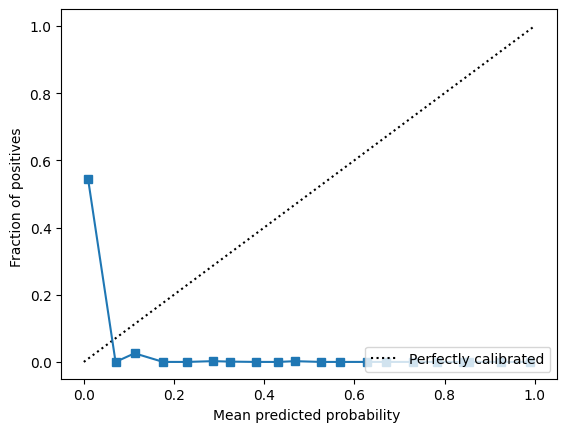

In [94]:
prob_true, prob_pred = calibration_curve(y_val, y_proba, n_bins=20)
disp = CalibrationDisplay(prob_true, prob_pred, y_proba)
disp.plot()
plt.show()

## Proba-Calibrated

In [82]:
from sklearn.calibration import CalibratedClassifierCV

In [83]:
cparams = { 
        'method': 'sigmoid',
#         'method': 'isotonic',
            'ensemble':True,
            'ensemble':False,
            'cv': 'prefit'}

In [84]:
calibrated = CalibratedClassifierCV(best_model, **cparams)

In [88]:
calibrated.fit(X_train, y_train, 
          sample_weight=w_train,
          group=groups['train'])

CalibratedClassifierCV(cv='prefit', ensemble=False,
                       estimator=LGBMRankerBinaryClassifier(colsample_bytree=0.8650357953850714,
                                                            learning_rate=1.5373880332812104,
                                                            max_bin=467,
                                                            max_depth=17,
                                                            min_child_samples=51,
                                                            min_child_weight=1e-05,
                                                            n_estimators=458,
                                                            num_leaves=147,
                                                            random_state=2024,
                                                            reg_alpha=4.4194339835245335,
                                                            reg_lambda=1.6102410861748417,
                                                            subsample=0.7792546242383102))

In [96]:
y_pred_c = calibrated.predict_proba(X_val)[:, 1]
y_c = calibrated.predict(X_val)

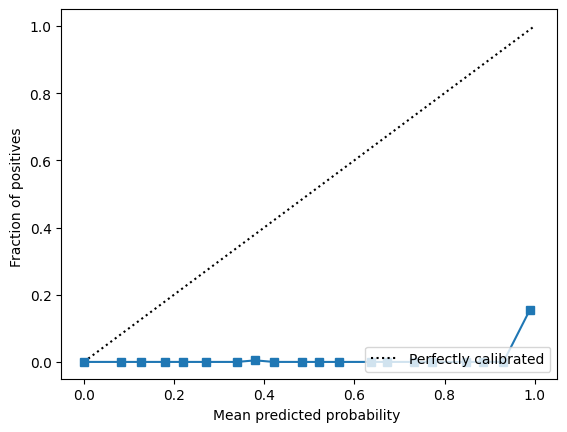

In [97]:
prob_true, prob_pred = calibration_curve(y_val, y_pred_c, n_bins=20)
disp = CalibrationDisplay(prob_true, prob_pred, y_pred_c)
disp.plot()

In [98]:
prec, recall, step = precision_recall_curve(y_val, y_pred_c, pos_label=1)

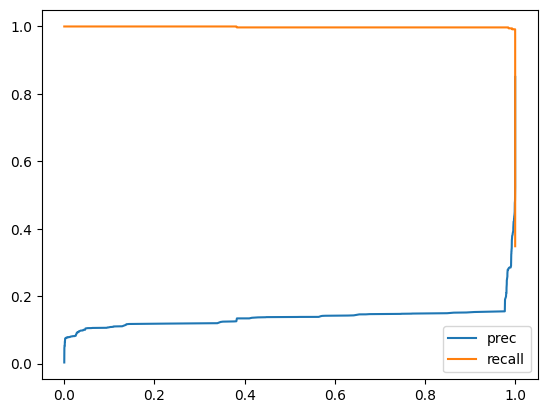

In [99]:
curve_df = pd.DataFrame({'prec':prec[:-1], 'recall':recall[:-1]}, index=step)
curve_df.plot();

In [100]:
run_name = 'lgbm_ranker_calibrated'

with mlflow.start_run(run_name=run_name):
    best_model.fit(X_train, y_train, 
          sample_weight=w_train,
          group=groups['train'])

    calibrated = CalibratedClassifierCV(best_model, **cparams)
    calibrated.fit(X_train, y_train, 
          sample_weight=w_train,
          group=groups['train'])
    mlflow.set_tags({'model':'lgbm_ranking_calibrated'})
#     mlflow.log_params(model.get_params())

    signature = infer_signature(X_train, y_train)
    
    mlflow.sklearn.log_model(
        calibrated,
        signature=signature,
        registered_model_name=metaflow_config["model_name"],
        artifact_path="model",
        metadata={'model': 'lgbm_ranking'},
        input_example=X_train.head(5),
    )

    val_metrics = {
        f"val_{scorer._score_func.__name__}": scorer(calibrated, X_old_val, y_old_val)
        for scorer in METRICS
    }
    mlflow.log_metrics(val_metrics)

[LightGBM] [Info] Calculating query weights...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.245192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3018
[LightGBM] [Info] Number of data points in the train set: 972614, number of used features: 17
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Ligh

/Users/philippk/Library/Caches/pypoetry/virtualenvs/transaction-matching-i9O2AM3V-py3.10/lib/python3.10/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


NameError: name 'metaflow_config' is not defined

In [101]:
print('!')

!
